### VQ-VAE Speech

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
import pandas as pd
from pathlib import Path

### Preparing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Path to the extracted dataset
DATASET_PATH = "/content/drive/MyDrive/adv_stats_proj/LibriSpeech"

# Function to load metadata
def load_metadata(dataset_path):
    metadata = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".flac"):
                file_path = os.path.join(root, file)
                speaker_id = root.split("/")[-2]
                chapter_id = root.split("/")[-1]
                metadata.append({
                    "file_path": file_path,
                    "speaker_id": speaker_id,
                    "chapter_id": chapter_id
                })
    return pd.DataFrame(metadata)

# Load metadata
metadata_df = load_metadata(DATASET_PATH)

In [18]:
metadata_df

,file_path,speaker_id,chapter_id
0,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,2412,153948
1,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,2412,153948
2,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,2412,153948
3,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,2412,153948
4,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,2412,153948
...,...,...,...
2698,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,3576,138058
2699,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,3576,138058
2700,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,3576,138058
2701,/content/drive/MyDrive/adv_stats_proj/LibriSpe...,3576,138058


In [ ]:
metadata_df['speaker_id'].value_counts()

,count
speaker_id,
3752,101
6313,96
2277,95
1462,94
3081,90
2428,87
5694,83
777,82
5895,80


In [ ]:
metadata_df['speaker_id'].value_counts()

,count
speaker_id,
3752,101
6313,96
2277,95
1462,94
3081,90
2428,87
5694,83
777,82
5895,80


In [ ]:
# Add audio durations to metadata
def get_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

metadata_df["duration"] = metadata_df["file_path"].apply(get_duration)

# Print basic stats
print(f"Total audio files: {len(metadata_df)}")
print(metadata_df["duration"].describe())

KeyboardInterrupt: 

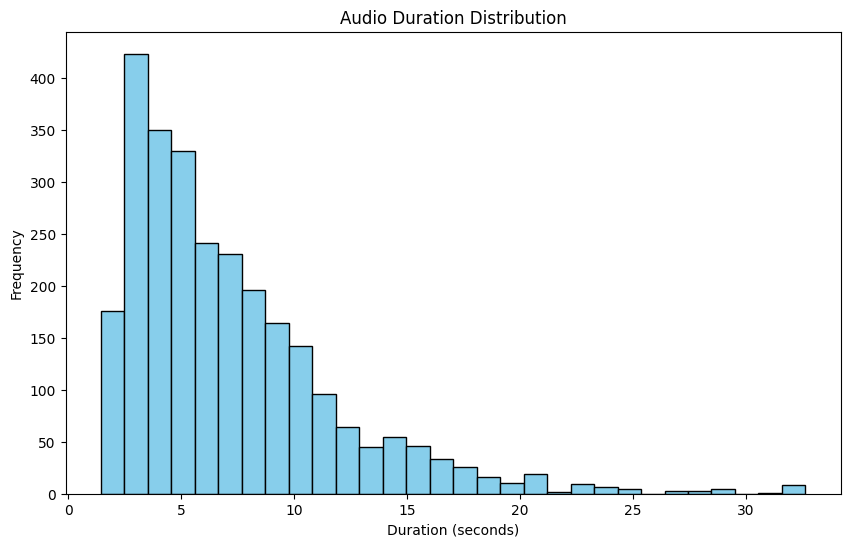

In [ ]:
# Plot duration distribution
plt.figure(figsize=(10, 6))
plt.hist(metadata_df["duration"], bins=30, color='skyblue', edgecolor='black')
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

Visualizing: /content/drive/MyDrive/LibriSpeech/dev-clean/2412/153948/2412-153948-0010.flac


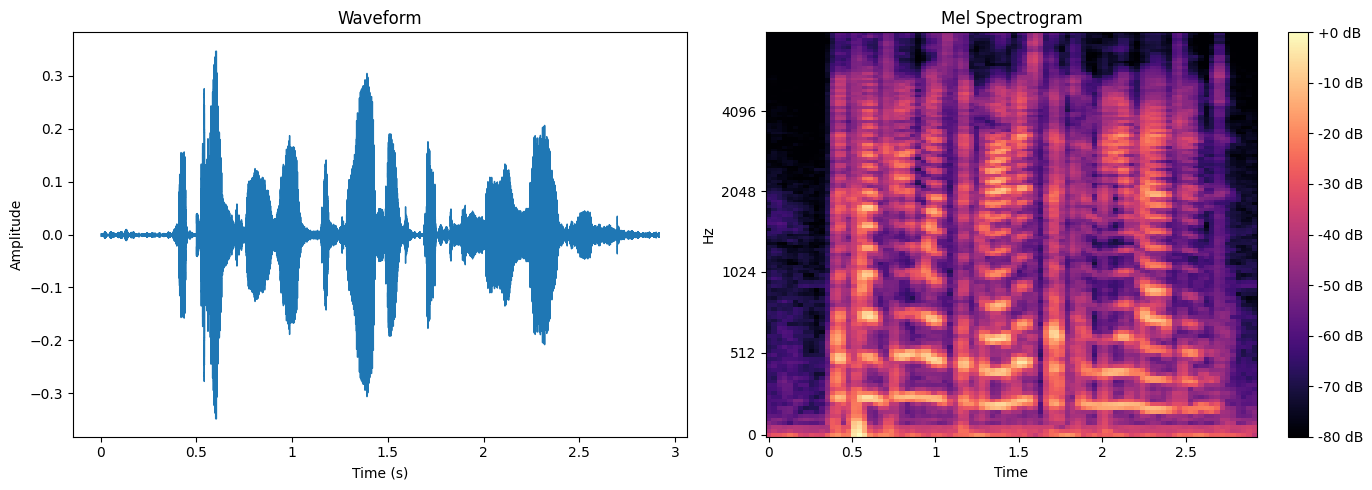

In [ ]:
# Visualize a waveform and spectrogram
def plot_waveform_and_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
    plt.figure(figsize=(14, 5))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(1, 2, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

# Visualize a sample audio file
sample_file = metadata_df.iloc[0]["file_path"]
print(f"Visualizing: {sample_file}")
plot_waveform_and_spectrogram(sample_file)

In [ ]:
# Preprocessing: Normalize and pad/truncate to fixed length
FIXED_LENGTH = 10.0  # in seconds

def preprocess_audio(file_path, fixed_length=FIXED_LENGTH):
    y, sr = librosa.load(file_path, sr=16000)
    target_length = int(fixed_length * sr)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), mode='constant')
    else:
        y = y[:target_length]
    return y, sr

# Save preprocessed audio for a few samples
output_dir = Path("preprocessed_audio")
output_dir.mkdir(exist_ok=True)

import soundfile as sf # Import the soundfile library

for idx, row in metadata_df.iterrows():
    if idx % 100 == 0:
        print(f"Processing row index: {idx}")
    audio, sr = preprocess_audio(row["file_path"])
    output_path = output_dir / f"{Path(row['file_path']).stem}_processed.wav"
    # Use soundfile.write instead of librosa.output.write_wav
    sf.write(output_path, audio, sr)
    #if idx >= 400:  # Process a limited number for demonstration
    #    break

print(f"Preprocessed audio saved to: {output_dir}")

Processing row index: 0
Processing row index: 100
Processing row index: 200
Processing row index: 300
Processing row index: 400
Processing row index: 500
Processing row index: 600
Processing row index: 700
Processing row index: 800
Processing row index: 900
Processing row index: 1000
Processing row index: 1100
Processing row index: 1200
Processing row index: 1300
Processing row index: 1400
Processing row index: 1500
Processing row index: 1600
Processing row index: 1700
Processing row index: 1800
Processing row index: 1900
Processing row index: 2000
Processing row index: 2100
Processing row index: 2200
Processing row index: 2300
Processing row index: 2400
Processing row index: 2500
Processing row index: 2600
Processing row index: 2700
Preprocessed audio saved to: preprocessed_audio


In [ ]:
processed_metadata_df = pd.DataFrame(audio)

In [ ]:
def load_data(data_dir):
    data_files = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                data_files.append(os.path.join(root, file))
    return data_files

def data_loader(file_list, batch_size=16):
    for i in range(0, len(file_list), batch_size):
        batch_files = file_list[i:i + batch_size]
        batch_audio = []
        for file_path in batch_files:
            y, _ = librosa.load(file_path, sr=16000)
            batch_audio.append(torch.tensor(y[:16000]).unsqueeze(0))  # Fixed-length waveforms
        batch_audio = torch.stack(batch_audio, dim=0)
        yield batch_audio, batch_audio

# Load data and split
data_files = load_data("preprocessed_audio")  # Replace with your directory
train_files, val_files = train_test_split(data_files, test_size=0.2, random_state=42)

### Modeling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)

    def forward(self, x):
        # Flatten input
        flat_x = x.permute(0, 2, 1).contiguous().view(-1, self.embedding_dim)
        distances = (
            torch.sum(flat_x**2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight**2, dim=1)
            - 2 * torch.matmul(flat_x, self.embeddings.weight.t())
        )
        # Get closest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and reshape
        quantized = torch.matmul(encodings, self.embeddings.weight).view(*x.shape)
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = self.beta * e_latent_loss + q_latent_loss

        # Add quantization noise
        quantized = x + (quantized - x).detach()
        return quantized, loss, encoding_indices


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose1d(latent_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose1d(hidden_dim, output_dim, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_embeddings):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.quantizer = VectorQuantizer(num_embeddings, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, _ = self.quantizer(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss

In [ ]:
import torch.optim as optim

# Hyperparameters
input_dim = 1
hidden_dim = 128
latent_dim = 64
num_embeddings = 512
learning_rate = 1e-3
epochs = 4

vqvae = VQVAE(input_dim, hidden_dim, latent_dim, num_embeddings)
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)

train_recon_losses, val_recon_losses = [], []
train_perplexities, val_perplexities = [], []

for epoch in range(epochs):
    # Training
    vqvae.train()
    total_train_loss, total_train_recon_loss, total_train_perplexity = 0, 0, 0
    num_train_batches = 0

    for x, target in data_loader(train_files, batch_size=64):
        x, target = x.float(), target.float()
        optimizer.zero_grad()
        x_recon, vq_loss = vqvae(x)
        recon_loss = F.mse_loss(x_recon, target)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_recon_loss += recon_loss.item()
        _,qloss, encoding_indices = vqvae.quantizer(x_recon)
        train_perplexity = (torch.histc(encoding_indices.float(), bins=num_embeddings, min=0, max=num_embeddings) > 0).float().mean().item()
        total_train_perplexity += train_perplexity
        num_train_batches += 1

    train_recon_losses.append(total_train_recon_loss / num_train_batches)
    train_perplexities.append(total_train_perplexity / num_train_batches)

    # Validation
    vqvae.eval()
    total_val_recon_loss, total_val_perplexity = 0, 0
    num_val_batches = 0

    with torch.no_grad():
        for x, target in data_loader(val_files, batch_size=16):
            x, target = x.float(), target.float()
            x_recon, vq_loss = vqvae(x)
            recon_loss = F.mse_loss(x_recon, target)
            total_val_recon_loss += recon_loss.item()
            _,qloss, encoding_indices = vqvae.quantizer(x_recon)
            val_perplexity = (torch.histc(encoding_indices.float(), bins=num_embeddings, min=0, max=num_embeddings) > 0).float().mean().item()
            total_val_perplexity += val_perplexity
            num_val_batches += 1

    val_recon_losses.append(total_val_recon_loss / num_val_batches)
    val_perplexities.append(total_val_perplexity / num_val_batches)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train - Recon Loss: {train_recon_losses[-1]:.4f}, Perplexity: {train_perplexities[-1]:.4f}")
    print(f"Val   - Recon Loss: {val_recon_losses[-1]:.4f}, Perplexity: {val_perplexities[-1]:.4f}")


Epoch 1/4
Train - Recon Loss: 0.0087, Perplexity: 0.0353
Val   - Recon Loss: 0.0054, Perplexity: 0.0039
Epoch 2/4
Train - Recon Loss: 0.0060, Perplexity: 0.2588
Val   - Recon Loss: 0.0053, Perplexity: 0.3150
Epoch 3/4
Train - Recon Loss: 0.0060, Perplexity: 0.1930
Val   - Recon Loss: 0.0053, Perplexity: 0.0548
Epoch 4/4
Train - Recon Loss: 0.0059, Perplexity: 0.1951
Val   - Recon Loss: 0.0053, Perplexity: 0.1625


### Results

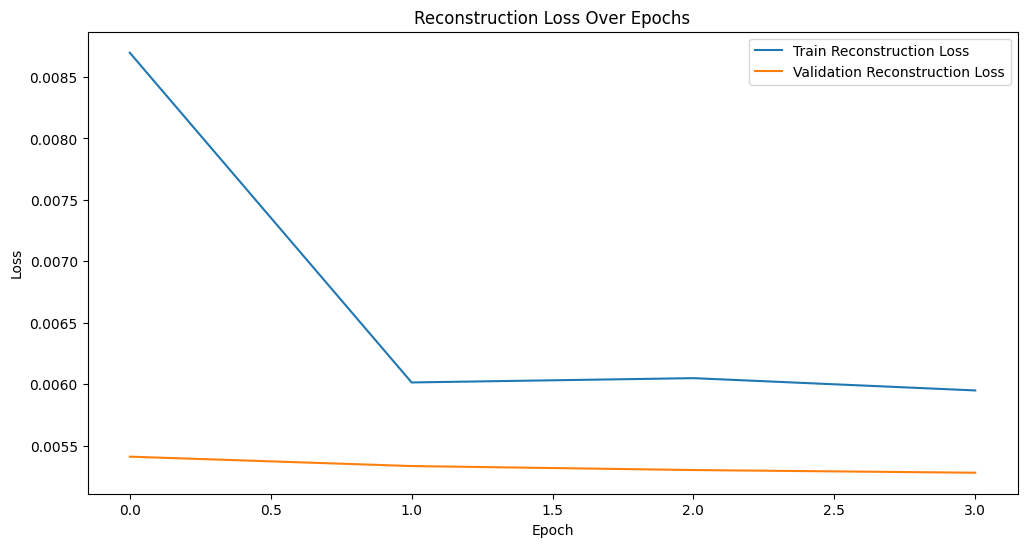

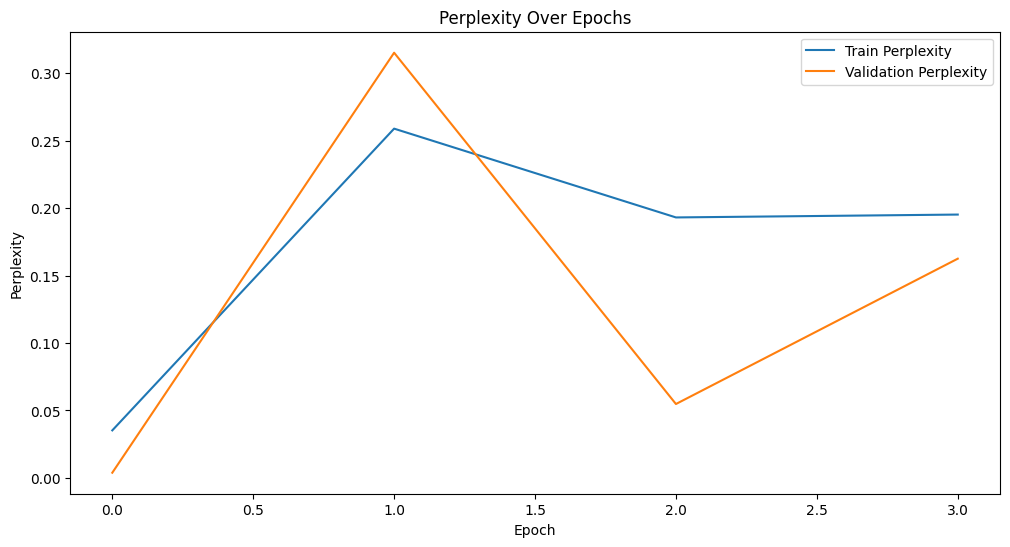

In [ ]:
# Plot Metrics
plt.figure(figsize=(12, 6))
plt.plot(train_recon_losses, label="Train Reconstruction Loss")
plt.plot(val_recon_losses, label="Validation Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reconstruction Loss Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_perplexities, label="Train Perplexity")
plt.plot(val_perplexities, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity Over Epochs")
plt.legend()
plt.show()

In [ ]:
len(val_files)

81

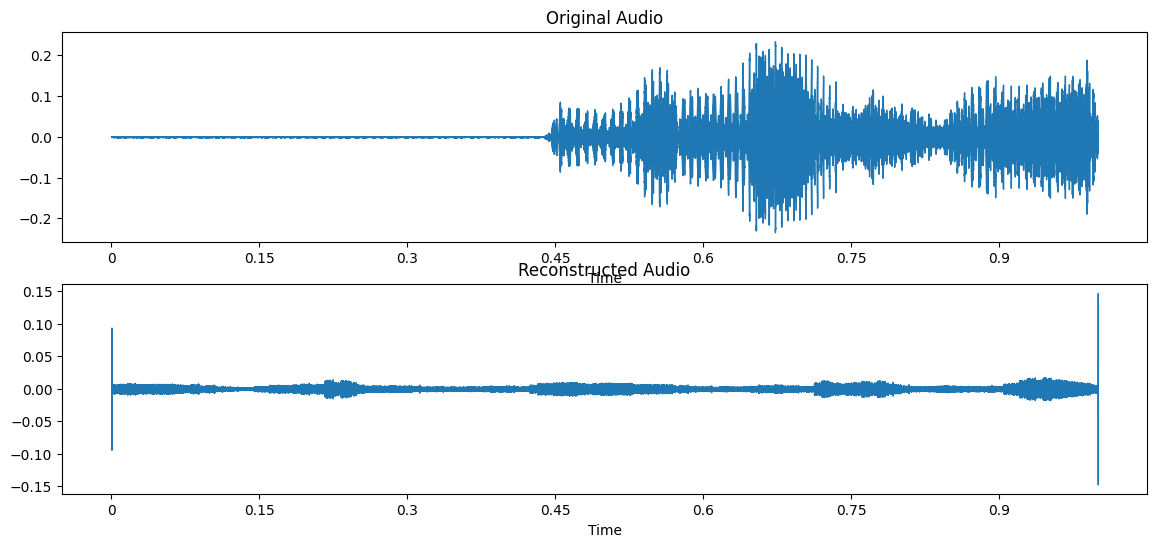

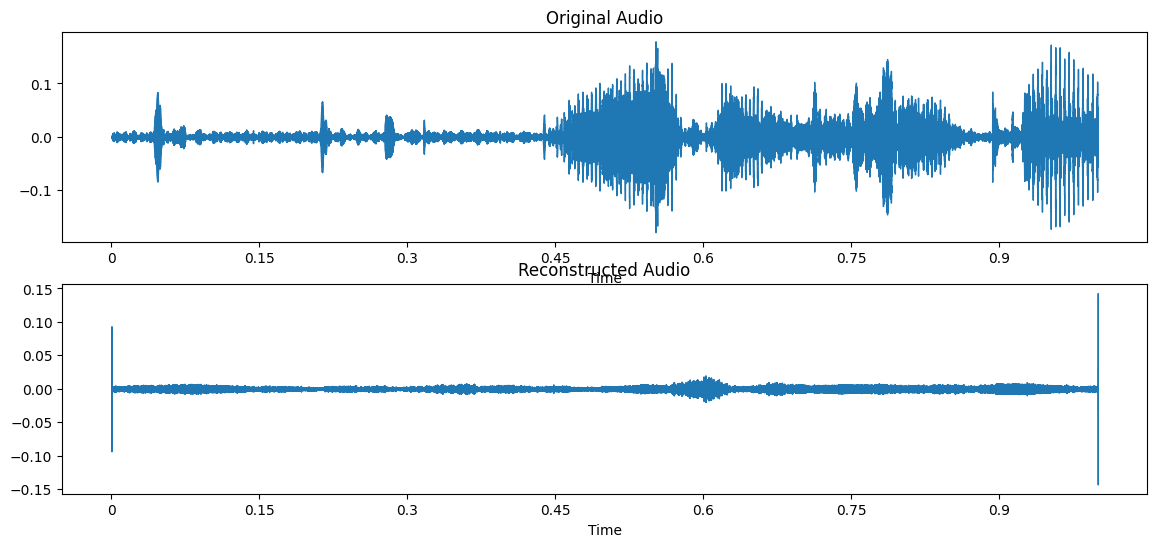

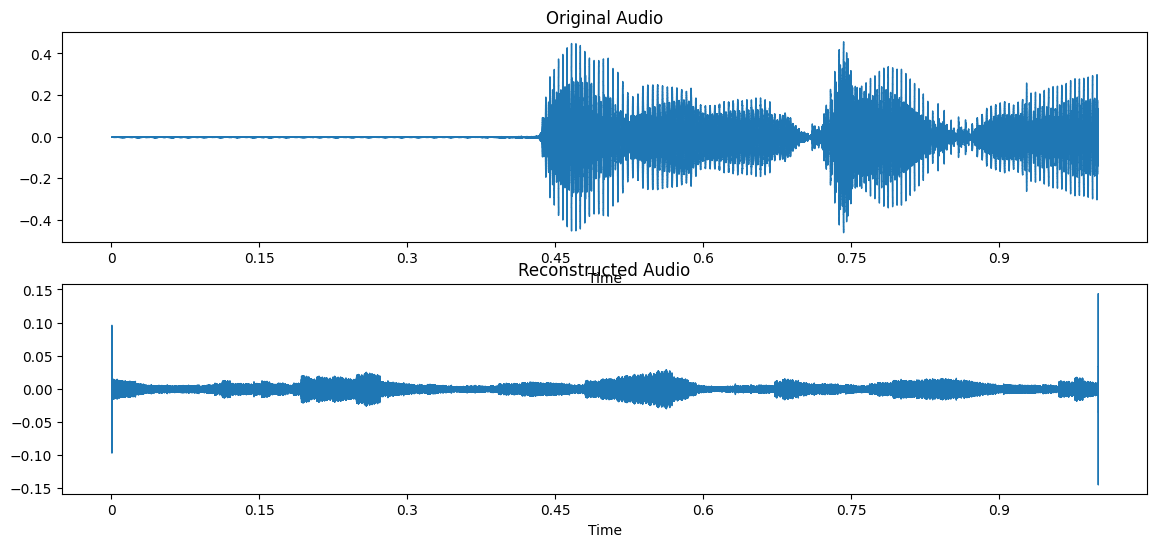

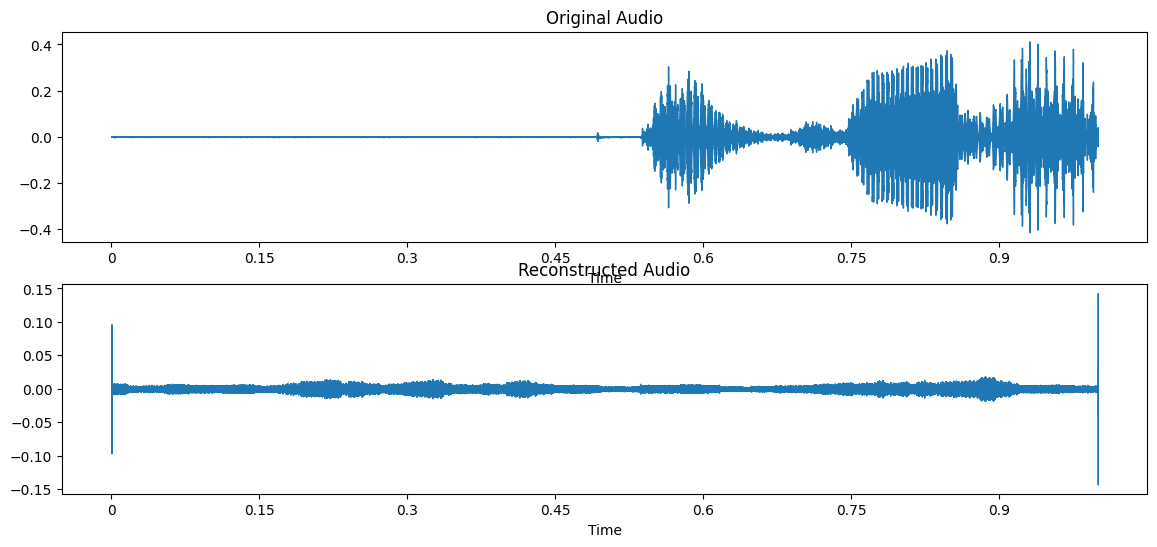

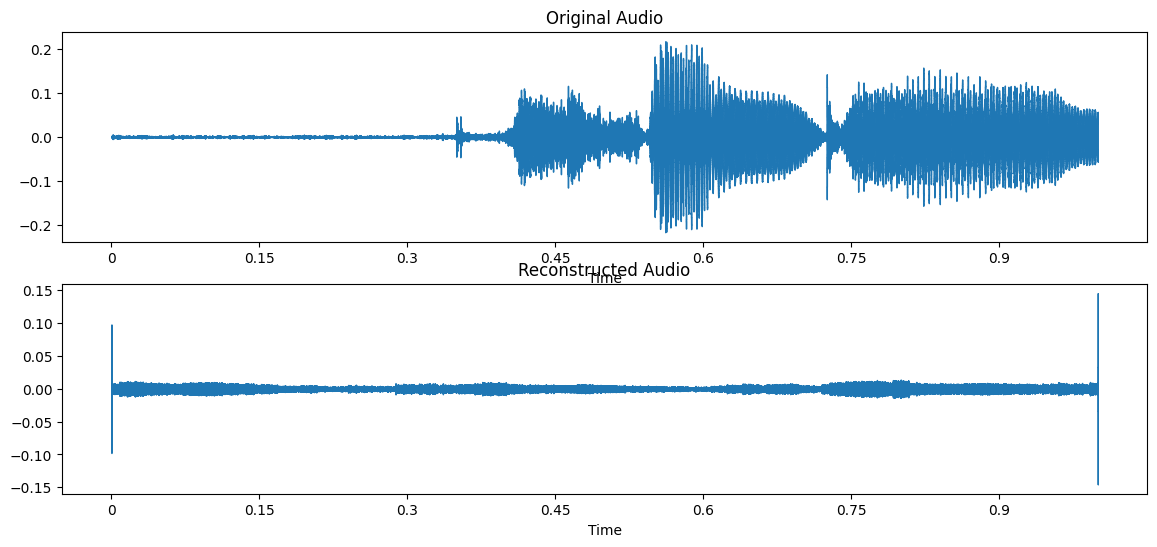

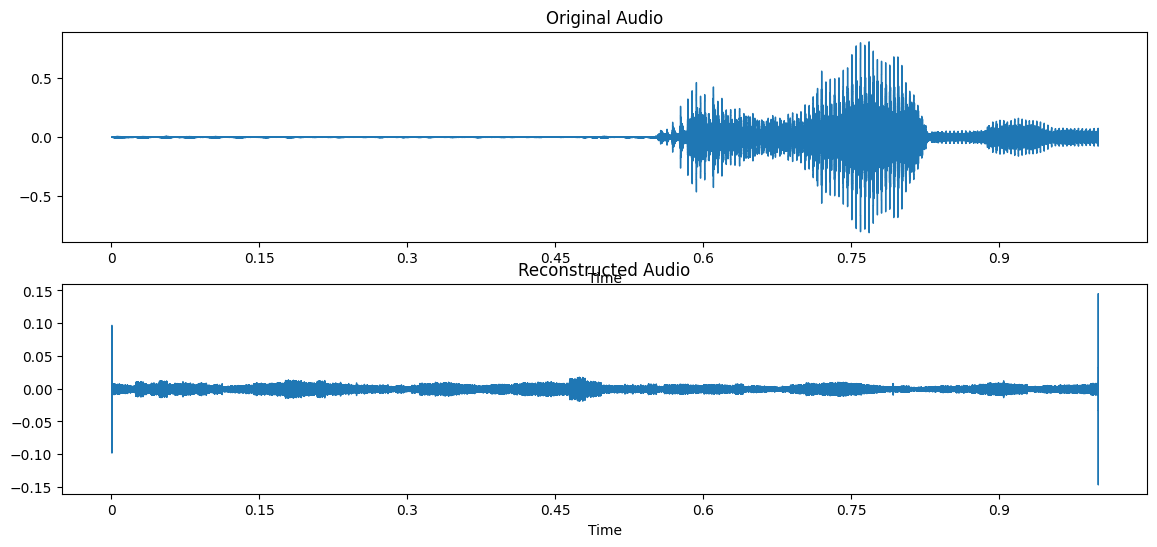

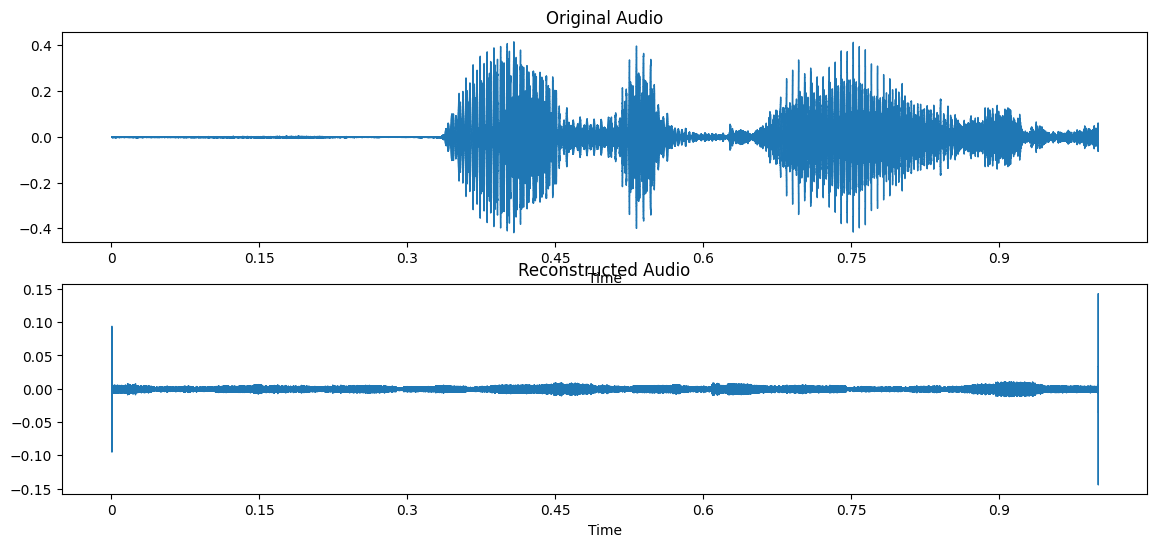

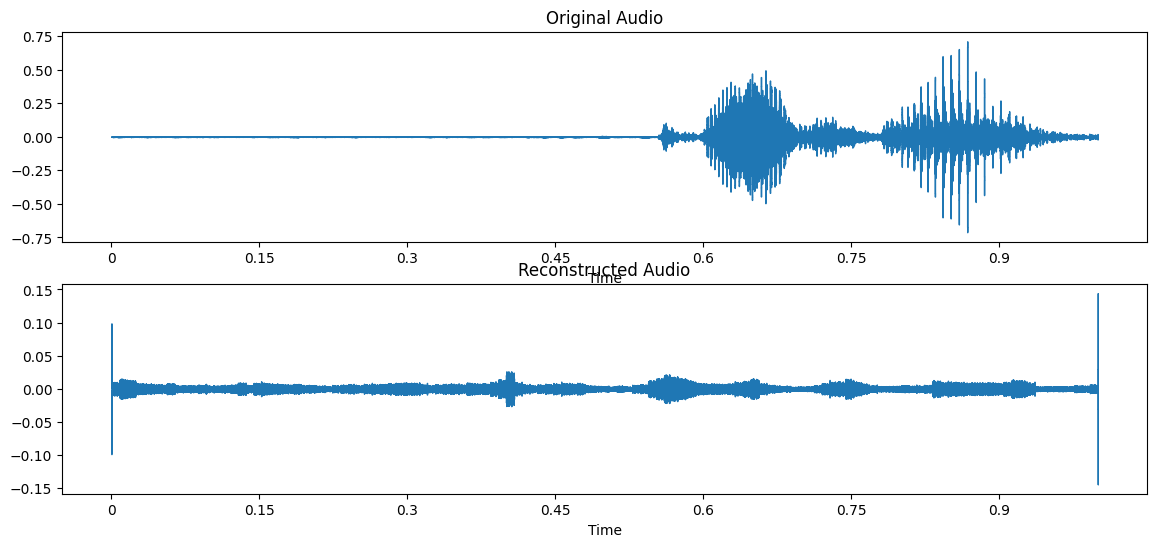

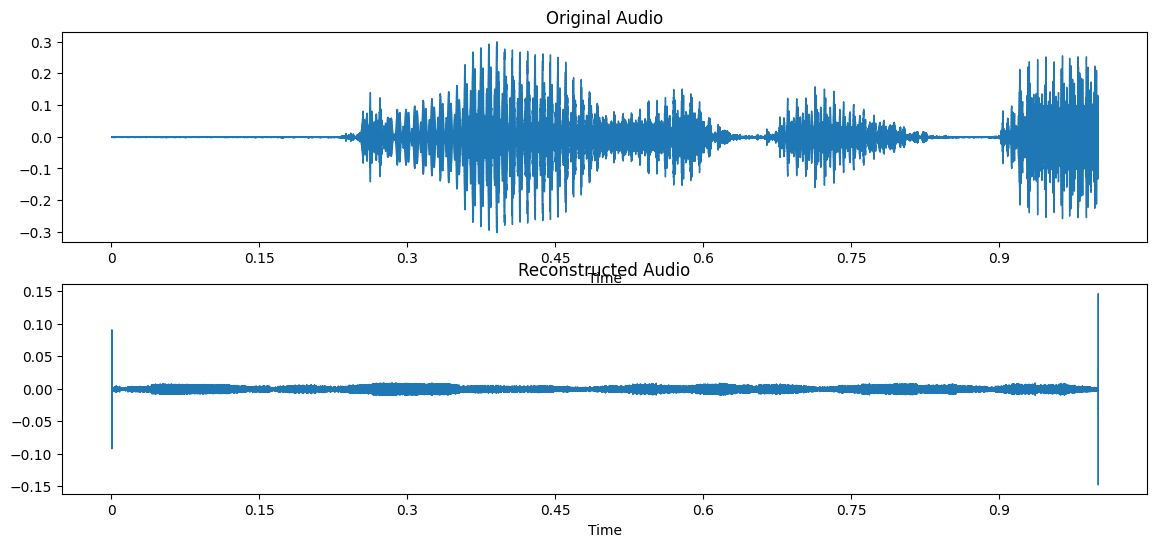

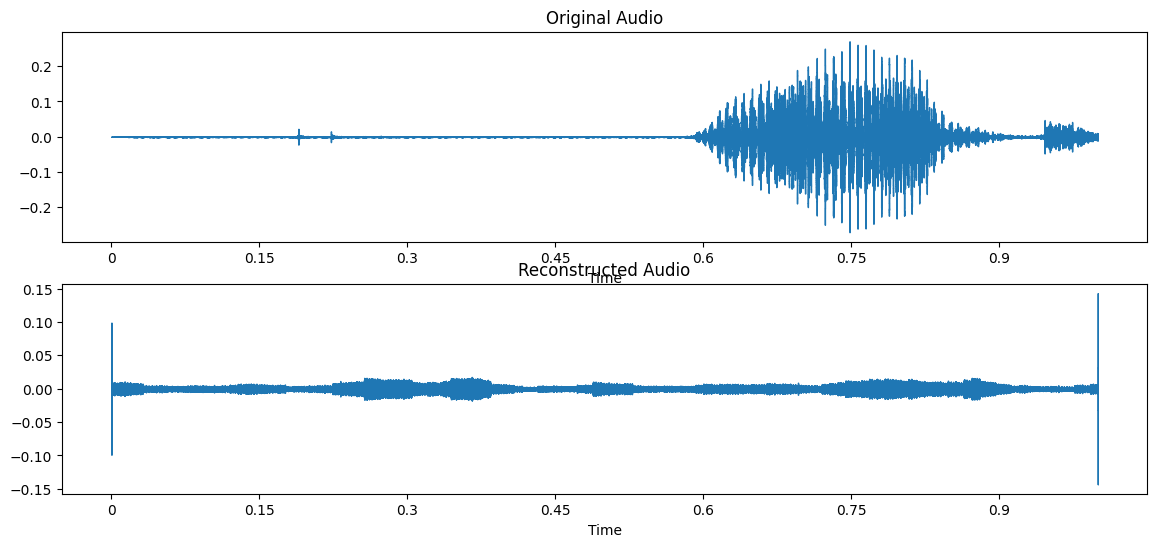

In [ ]:
# Compare Original and Reconstructed
for i in range(10):
  sample_file = val_files[i]
  original_audio, _ = librosa.load(sample_file, sr=16000)
  original_audio = torch.tensor(original_audio[:16000]).unsqueeze(0).unsqueeze(0).float()

  vqvae.eval()
  with torch.no_grad():
      reconstructed_audio, _ = vqvae(original_audio)

  # Convert tensors to numpy arrays
  reconstructed_audio = reconstructed_audio.detach().numpy()[0][0]

  plt.figure(figsize=(14, 6))
  plt.subplot(2, 1, 1)
  librosa.display.waveshow(original_audio.squeeze(0).numpy(), sr=16000)
  plt.title("Original Audio")
  plt.subplot(2, 1, 2)
  librosa.display.waveshow(reconstructed_audio, sr=16000)
  plt.title("Reconstructed Audio")
  plt.show()